In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xa
from glob import glob
import pandas as pd
import datetime

In [33]:
def to_decimal_year(time):
    dt = pd.to_datetime(time) # converts np.datetime64 into datetime object
    dec_year = []
    for i in range(len(dt)):
        start = datetime.date(dt[i].year,1,1).toordinal()
        year_length = datetime.date(dt[i].year+1, 1, 1).toordinal() - start
        dec_year.append(dt[i].year + (float(dt[i].toordinal() - start) / year_length)) # calculates how much time has passed in the year, divides by year length, then adds to start year
    return np.array(dec_year)

In [3]:
def detrend_from_coefs(time,values,coefs):
    yr = to_decimal_year(time)
    
    mean = coefs[0]
    trend = coefs[1]*(yr-np.mean(yr))
    res_coefs = coefs[2:]
    
    detrended = values.copy()
    detrended -= mean
    detrended -= trend
    for j in range(0,len(res_coefs),2):
        omega = (j+2)*np.pi
        detrended -= (res_coefs[j]*np.sin(omega*yr))+(res_coefs[j+1]*np.cos(omega*yr))
    
    return detrended
                                                         
    

In [4]:
# Extract data
files = np.sort(glob('/Users/erickson/Documents/Data/RFROM/*.nc'))
data = xa.open_mfdataset(files)

In [5]:
# extract coefficients 
coefs = Dataset('trend.nc','r')

In [6]:
latitude = data.variables['latitude'].values
longitude = data.variables['longitude'].values
time = data['time'].values

In [7]:
year = to_decimal_year(time)

Test with one location

In [12]:
lat = 45
lon = -140
latind = np.argmin(np.abs(latitude-lat))
lonind = np.argmin(np.abs(np.mod(longitude-lon,360)))
coef = coefs.variables['coefs'][:,0,latind,lonind]
detrended = detrend_from_coefs(time,data['ocean_temperature'][:,0,latind,lonind].values,coef)

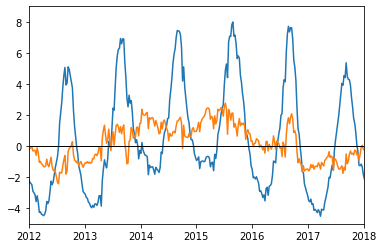

In [43]:
plt.plot(year,data['ocean_temperature'][:,0,latind,lonind].values-np.mean(data['ocean_temperature'][:,0,latind,lonind].values))
plt.plot(year,detrended)
plt.xlim([2012,2018])
plt.ylim([-5,9])
plt.axhline(0,c='k',lw=1)

In [8]:
deps = [2.5,100,150,200]
depinds = np.array([np.where(data['mean_pressure'].values==d)[0][0] for d in deps])

In [9]:
MHW_threshold = np.empty(shape=(len(deps),len(latitude),len(longitude)))
MHW_cum = np.empty(shape=(len(deps),len(latitude),len(longitude)))

In [19]:
for i in range(len(deps)):
    print(deps[i])
    for j in range(len(latitude)):
        print('%d'%latitude[j],end=' ')
        for k in range(len(longitude)):
            if np.isnan(coefs.variables['coefs'][0,depinds[i],j,k]):
                continue
            vals = data.variables['ocean_temperature'][:,depinds[i],j,k].values
            coef = coefs.variables['coefs'][:,depinds[i],j,k]
            detrended = detrend_from_coefs(time,vals,coef)
            MHW_threshold[i,j,k] = np.percentile(detrended,90)
            MHW_cum[i,j,k] = np.sum(detrended[detrended>MHW_threshold[i,j,k]]-MHW_threshold[i,j,k])
    print('')

100
-89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 
150
-89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 1

In [28]:
MHW_nc = Dataset('MHW_intensity.nc','w')
MHW_nc.createDimension('depth',4)
MHW_nc.createDimension('latitude',180)
MHW_nc.createDimension('longitude',360)
var = MHW_nc.createVariable('depth','f4',('depth'))
var.units = 'dbar'
var[:] = deps
MHW_nc.createVariable('latitude','f4',('latitude'))[:] = latitude
MHW_nc.createVariable('longitude','f4',('longitude'))[:] = longitude
var = MHW_nc.createVariable('MHW_intensity','f8',('depth','latitude','longitude'))
var.units = 'deg C yr-1'
var.history = 'sum of deg C above MHW threshold (90\% of detrended data) for weekly data, multiplied by 7 and divided by the timeseries length (31 years)'
var[:] = MHW_cum*7/31
MHW_nc.close()